In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import matplotlib as mpl
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

# Pattern Spectra (PS)

![](img/ps.svg)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [2]:
# Your turn!

tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
with rio.open(tile_path) as src:
    dsm = src.read(1)  # Read the first band
dsm_no_nan = np.nan_to_num(dsm, nan=-9999)
dsm_no_nan = dsm_no_nan.astype(np.float16)
print(dsm_no_nan)

max_tree = sap.MaxTree(dsm_no_nan)
print(max_tree.num_nodes)

[[29.14 29.12 29.12 ... 50.75 53.16 52.88]
 [29.16 29.14 29.12 ... 48.75 53.9  53.9 ]
 [30.58 29.97 29.11 ... 50.56 54.6  54.25]
 ...
 [43.56 43.53 43.56 ... 48.3  48.53 45.38]
 [43.12 43.16 43.16 ... 46.94 47.22 45.84]
 [42.97 42.7  43.   ... 46.06 47.12 46.53]]
<bound method Tree.num_nodes of MaxTree{'adjacency': 4,
 'image.dtype': dtype('float16'),
 'image.shape': (2001, 2001),
 'image_hash': '4d9ddb6b',
 'image_name': None,
 'num_nodes': 4081221}>


## 1. Compute attributes and visualize the distrbution of values

- Compute the `area` and `compactness` attributes
- How can we visualize the distribution of values? Display the distribution of areas, then compactness.
    + Tip: you can some matplotlib functions to plot the visualizations!

In [3]:
# Your turn!

area = max_tree.get_attribute("area")  # Compute area attribute
compact = max_tree.get_attribute("compactness")  # Compute compactness attribute
print('area', area[:50])
print("---------------------------------")
print('comapctness', compact[:50])

area [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
---------------------------------
comapctness [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [4]:
print (area.shape, compact.shape)  # (shape: n_nodes,)

(4081221,) (4081221,)


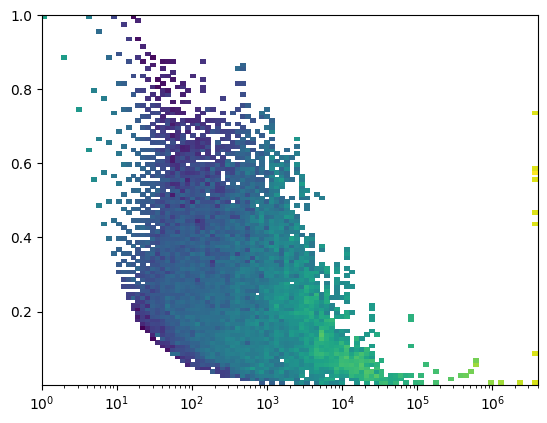

In [5]:
# displaying the pattern spectrum for the whole tree
ps = sap.spectrum2d(max_tree, 'area', 'compactness', x_log=True)
sap.show_spectrum(*ps)

In [6]:
print(f"Area range: [{area.min():.2f}, {area.max():.2f}]")
print(f"Compactness range: [{compact.min():.4f}, {compact.max():.4f}]")

Area range: [1.00, 4004001.00]
Compactness range: [0.0027, 1.0000]


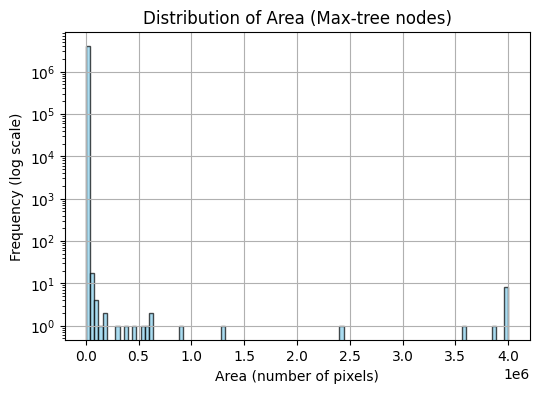

In [13]:
## distrubtion of area and compactness attributes

# remove invalid / degenerate nodes
# valid = (area >= 1) & np.isfinite(compact)
# area_valid = area[valid]
# compactness_valid = compact[valid]

# plotting area distribution
plt.figure(figsize=(6,4))
plt.hist(area, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Area (number of pixels)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Area (Max-tree nodes)")
plt.yscale('log')
plt.grid(True)
plt.show()




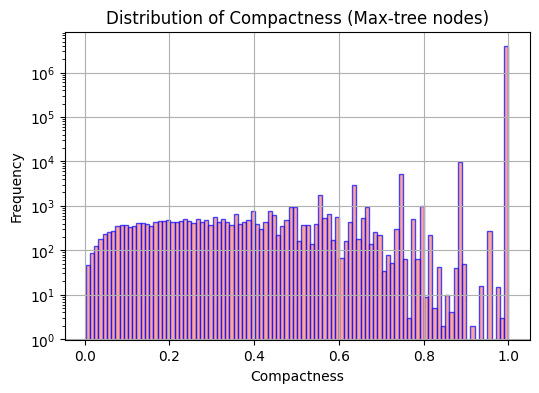

In [11]:
# plotting compactness distribution
plt.figure(figsize=(6,4))
plt.hist(compact, bins=100, color='salmon', edgecolor='blue', alpha=0.7)
plt.xlabel("Compactness")
plt.ylabel("Frequency")
plt.title("Distribution of Compactness (Max-tree nodes)")
plt.yscale('log')
plt.grid(True)
plt.show()


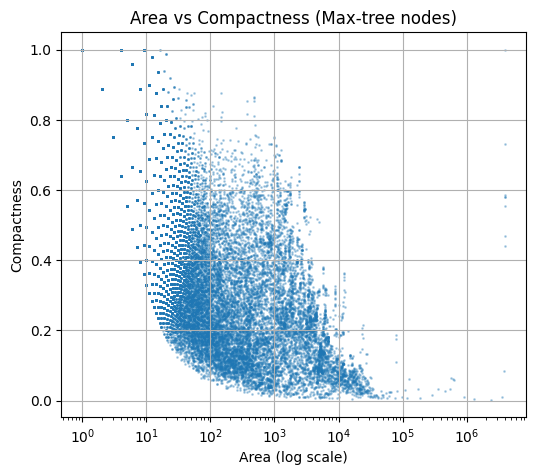

In [14]:
# scatter plot of area vs compactness
plt.figure(figsize=(6,5))
plt.scatter(area, compact, s=1, alpha=0.3)
plt.xscale("log")
plt.xlabel("Area (log scale)")
plt.ylabel("Compactness")
plt.title("Area vs Compactness (Max-tree nodes)")
plt.grid(True)
plt.show()


### SAme, sorry I thought there will be a differnce, maybe i must increase threshold :)

## Update: I put it to be >=10 ...
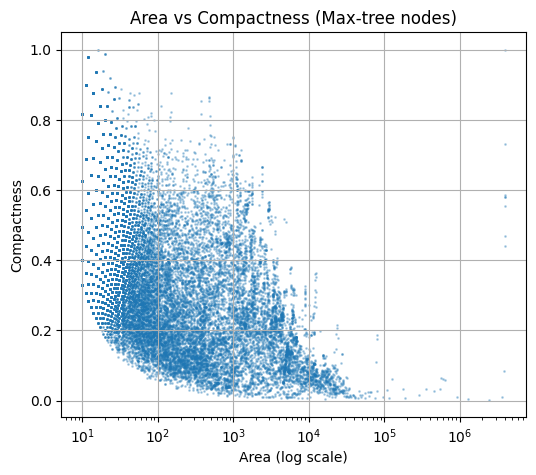]

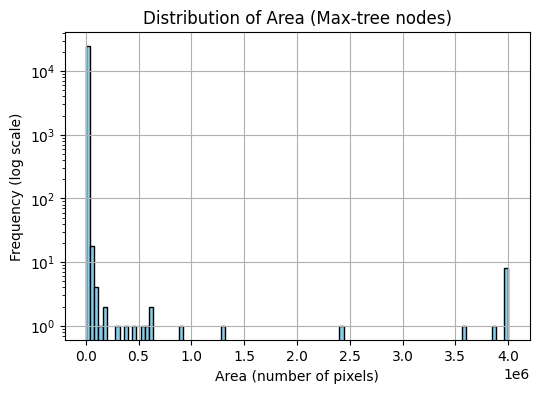

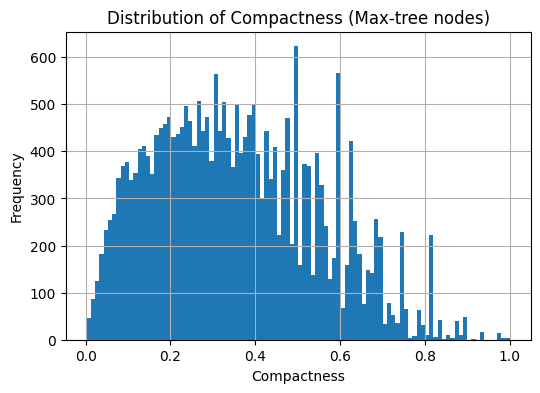


# 2. Compute a Pattern Spectrum

The pattern spectrum can be seen as nodes attributes probability distribution: for a given attribute value we display the probability to have nodes with these properties in the image.

To compute the Pattern Spectrum, you need to weight the histograms with the area of the flat zone times the height diffence of the flat zone and its direct ancester.

- Compute and display the Pattern Spectrum
    - For `area` attributes
    - For `compactness` attributes

In [11]:
# Your turn!
import higra as hg

parents = max_tree._tree.parents()
print(parents)  # shape: (n_nodes,)



[4065486 4065486 4065486 ... 4081220 4081220 4081220]


In [12]:
max_tree.available_attributes()

{'area': ['vertex_area=None', 'leaf_graph=None'],
 'child_number': [],
 'children_pair_sum_product': ['node_weights'],
 'compactness': ['area=None',
  'contour_length=None',
  'normalize=True',
  'leaf_graph=None'],
 'contour_length': ['vertex_perimeter=None',
  'edge_length=None',
  'leaf_graph=None'],
 'contour_strength': ['edge_weights',
  'vertex_perimeter=None',
  'edge_length=None',
  'leaf_graph=None'],
 'depth': [],
 'dynamics': ['altitudes', "increasing_altitudes='auto'"],
 'extinction_value': ['altitudes', 'attribute', "increasing_altitudes='auto'"],
 'extrema': ['altitudes'],
 'frontier_length': ['edge_length=None', 'leaf_graph=None'],
 'frontier_strength': ['edge_weights', 'leaf_graph'],
 'gaussian_region_weights_model': ['vertex_weights', 'leaf_graph=None'],
 'height': ['altitudes', "increasing_altitudes='auto'"],
 'lca_map': ['leaf_graph'],
 'mean_vertex_weights': ['vertex_weights', 'area=None', 'leaf_graph=None'],
 'moment_of_inertia': ['leaf_graph'],
 'piecewise_constan

In [13]:
altitudes = max_tree._alt
print(altitudes)  

[29 29 29 ... 17 17 16]


### I found this from Author : [Cyril Meyer](https://cyrilmeyer.eu/) 

So I will combute two attribute, named $\nabla_A$ and $\Delta_A$.

$\nabla_A(N) = \frac{\mid A(Par(N)) - A(N)\mid}{|H(Par(N))-H(N)|} \cdot \frac{1}{A(N)}$

$\Delta_A(N) = \nabla_A(Par(N)) - \nabla_A(N)$

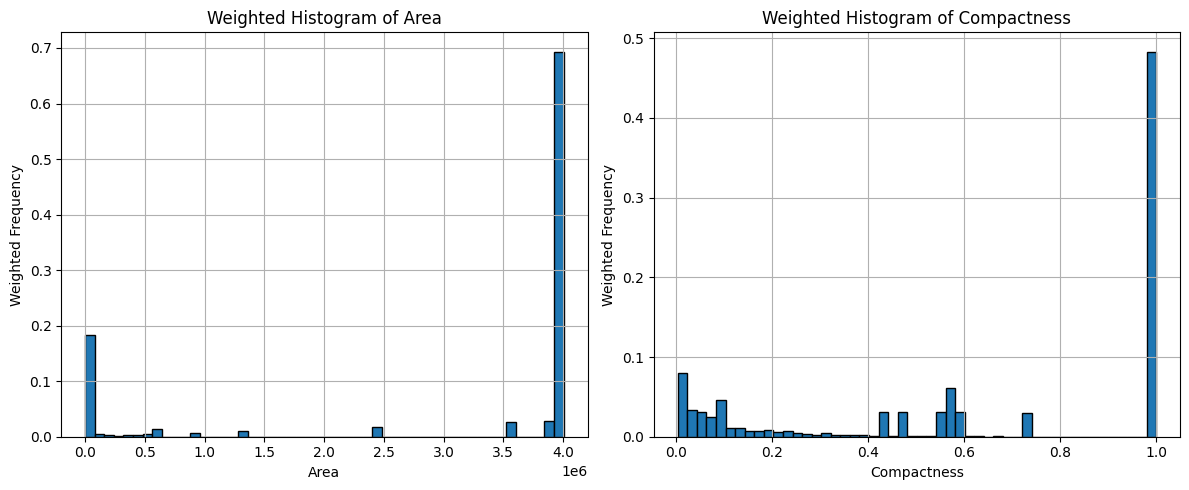

In [ ]:
# delta heights (altitudes difference with parent)
altitudes = max_tree._alt
parents = max_tree._tree.parents()
delta_h = altitudes - altitudes[parents]
delta_h[max_tree._tree.root()] = altitudes[max_tree._tree.root()]  # root node

# weights = area * delta_h
weights = area * delta_h

# histogram for area

hist_area, bins_area = np.histogram(area, bins=50, weights=weights)
hist_area = hist_area / np.sum(hist_area)  # normalize to probability

# hist for compactness
hist_comp, bins_comp = np.histogram(compact, bins=50, weights=weights)
hist_comp = hist_comp / np.sum(hist_comp)

# plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(bins_area[:-1], hist_area, width=np.diff(bins_area), edgecolor='black', align='edge')
plt.xlabel('Area')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram of Area')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.bar(bins_comp[:-1], hist_comp, width=np.diff(bins_comp), edgecolor='black', align='edge')
plt.xlabel('Compactness')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram of Compactness')
plt.grid(True)
plt.tight_layout()
plt.show()


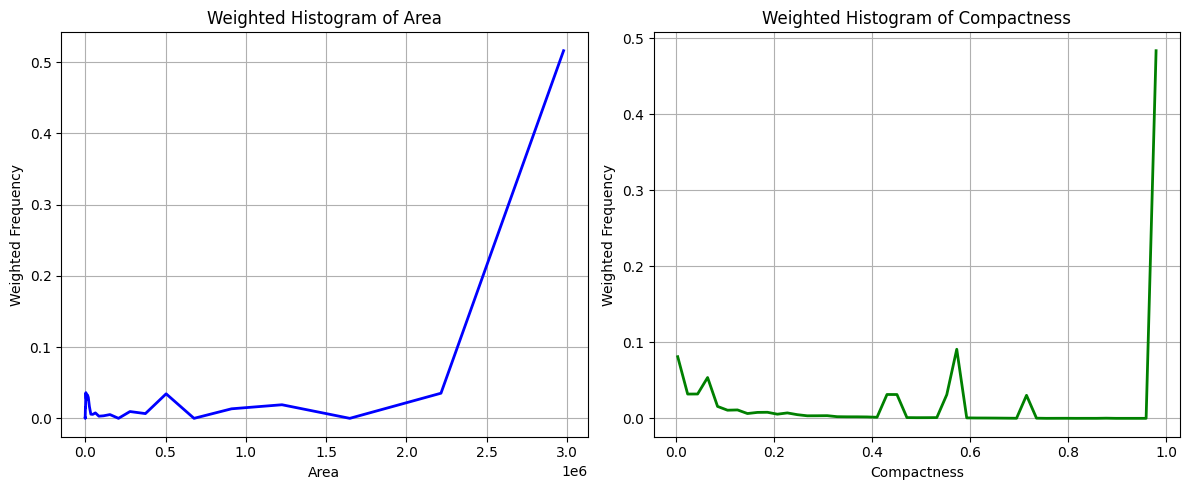

In [ ]:
# delta heights (altitudes difference with parent)
altitudes = max_tree._alt
parents = max_tree._tree.parents()
delta_h = altitudes - altitudes[parents]
delta_h[max_tree._tree.root()] = altitudes[max_tree._tree.root()]  # root node

# weights = area * delta_h
weights = area * delta_h

# histogram for area
area_bins = np.logspace(np.log10(area.min() + 1), np.log10(area.max()), 50)
compactness_bins = np.linspace(compact.min(), compact.max(), 50)
hist_area, bins_area = np.histogram(area, bins=area_bins, weights=weights)
hist_area = hist_area / np.sum(hist_area)  # normalize to probability

# hist for compactness
hist_comp, bins_comp = np.histogram(compact, bins=compactness_bins, weights=weights)
hist_comp = hist_comp / np.sum(hist_comp)

# plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(bins_area[:-1], hist_area, linewidth=2, color='blue')
plt.xlabel('Area')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram of Area')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(bins_comp[:-1], hist_comp, linewidth=2, color= 'green')
plt.xlabel('Compactness')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram of Compactness')
plt.grid(True)
plt.tight_layout()
plt.show() 


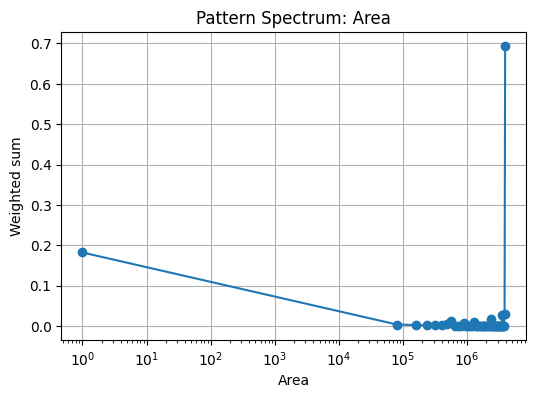

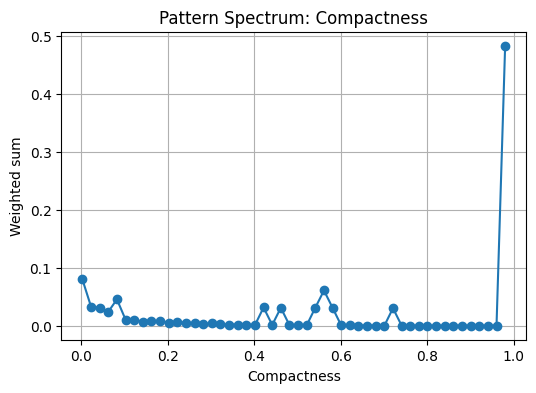

In [15]:
# Area PS
plt.figure(figsize=(6,4))
plt.plot(bins_area[:-1], hist_area, marker='o')
plt.xscale('log')
plt.xlabel("Area")
plt.ylabel("Weighted sum")
plt.title("Pattern Spectrum: Area")
plt.grid(True)
plt.show()

# Compactness PS
plt.figure(figsize=(6,4))
plt.plot(bins_comp[:-1], hist_comp, marker='o')
plt.xlabel("Compactness")
plt.ylabel("Weighted sum")
plt.title("Pattern Spectrum: Compactness")
plt.grid(True)
plt.show()


## 3. Compute and display a 2D Pattern Spectrum with SAP

- Compute a 2D PS with SAP
- Find objet of interrest in the spectrum
- Filter the DSM according to the object of interest in the spectum

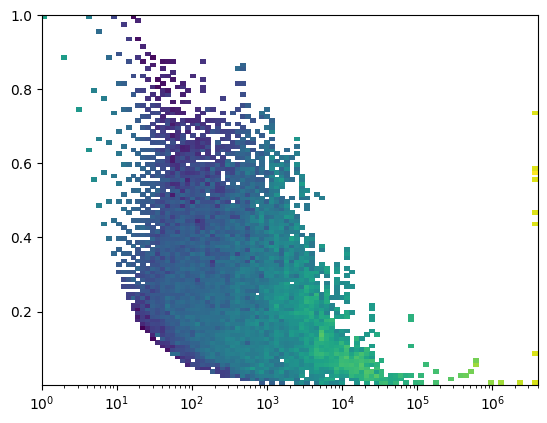

In [16]:
# Your turn!

PS_2D = sap.spectrum2d(max_tree, 'area', 'compactness', x_log=True)
sap.show_spectrum(*PS_2D)

In [17]:
# thresholds for object of interest
area_min, area_max = 100, 1000
compact_min, compact_max = 0.2, 0.4

# nodes filtering in the tree corresponding to objects
mask = (area >= area_min) & (area <= area_max) & \
       (compact >= compact_min) & (compact<= compact_max)
print(f"Number of selected nodes: {np.sum(mask)}")


Number of selected nodes: 2272


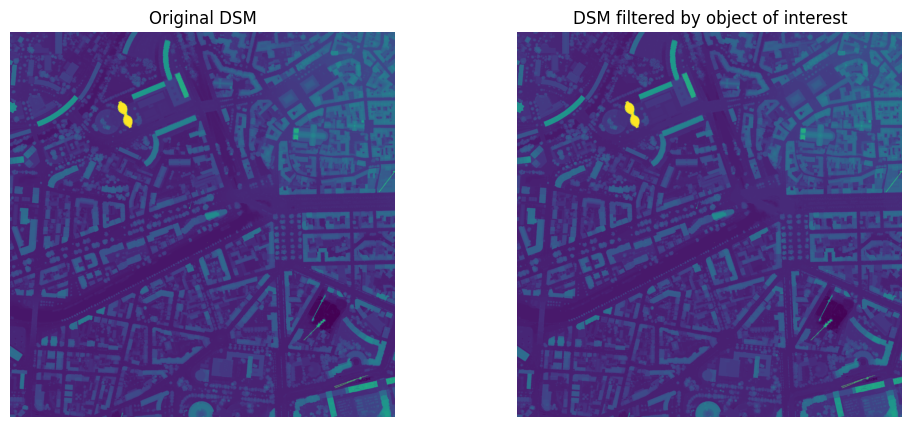

In [18]:
## reconstruct image from selected nodes
filtered_dsm_ps = max_tree.reconstruct(mask)

# Display before and after
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dsm_no_nan, cmap='viridis')
plt.title("Original DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_dsm_ps, cmap='viridis')
plt.title("DSM filtered by object of interest")
plt.axis("off")

plt.show()


In [19]:
filtered_dsm_ps.size

4004001

In [20]:
dsm_no_nan.size

4004001

In [30]:
dsm_no_nan.shape

(2001, 2001)

In [31]:
# mask image for the selected nodes
node_mask = np.zeros(dsm_no_nan.size, dtype=bool)

#all_vertices = hg.altitude(max_tree._tree)

all_vertices = hg.attribute_vertex_list(max_tree._tree)

for node_id, selected in enumerate(mask):
    if selected:
        pixels = all_vertices[node_id]  # list of leaf pixels in the node
        node_mask[pixels] = True

print("Number of pixels selected:", np.sum(node_mask))


Number of pixels selected: 314800


In [32]:
node_mask_2d = node_mask.reshape(dsm_no_nan.shape)
print(node_mask_2d.shape)

(2001, 2001)


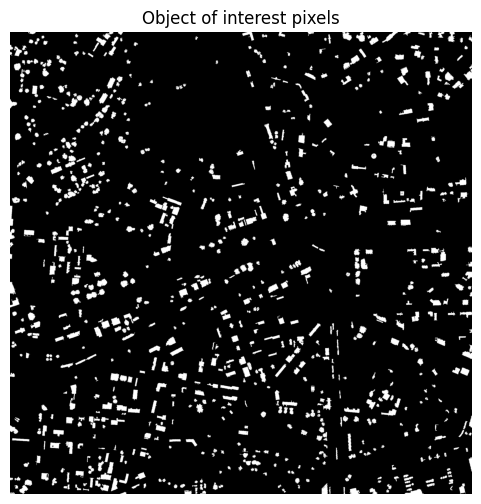

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(node_mask_2d, cmap='gray')
plt.title("Object of interest pixels")
plt.axis("off")
plt.show()


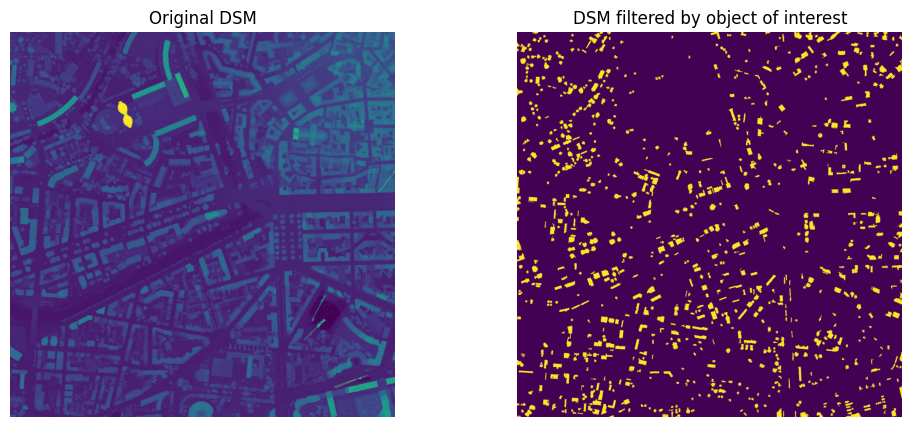

In [ ]:
# Display before and after
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dsm_no_nan, cmap='viridis')
plt.title("Original DSM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(node_mask_2d, cmap='viridis')
plt.title("DSM filtered by object of interest")
plt.axis("off")

plt.show()

## DRAFT

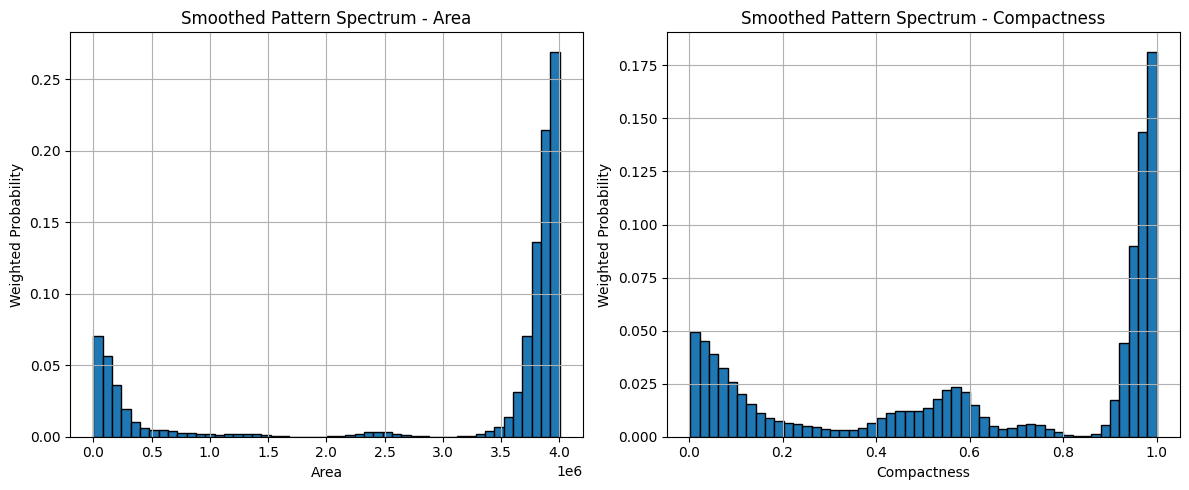

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Compute delta height
parents = max_tree._tree.parents()
altitudes = max_tree._alt
delta_h = altitudes - altitudes[parents]
delta_h[max_tree._tree.root()] = altitudes[max_tree._tree.root()]  # fix root

# Compute weights
area = max_tree.get_attribute('area')
compactness = max_tree.get_attribute('compactness')
weights = area * delta_h

# Histogram for area
hist_area, bins_area = np.histogram(area, bins=50, weights=weights)
hist_area = hist_area / np.sum(hist_area)  # normalize to probability
hist_area_smooth = gaussian_filter1d(hist_area, sigma=2)  # smooth

# Histogram for compactness
hist_comp, bins_comp = np.histogram(compactness, bins=50, weights=weights)
hist_comp = hist_comp / np.sum(hist_comp)
hist_comp_smooth = gaussian_filter1d(hist_comp, sigma=2)

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(bins_area[:-1], hist_area_smooth, width=np.diff(bins_area), edgecolor='black', align='edge')
plt.xlabel('Area')
plt.ylabel('Weighted Probability')
plt.title('Smoothed Pattern Spectrum - Area')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(bins_comp[:-1], hist_comp_smooth, width=np.diff(bins_comp), edgecolor='black', align='edge')
plt.xlabel('Compactness')
plt.ylabel('Weighted Probability')
plt.title('Smoothed Pattern Spectrum - Compactness')
plt.grid(True)

plt.tight_layout()
plt.show()
